# Sparse Linear Algebra

So far, we have seen how sparse matrices and linear operators can be used to speed up basic matrix-vector and matrix-matrix operations, and decrease the memory footprint of the representation of a linear map.

Just as there are special data types for sparse and structured matrices, there are specialized linear algebra routines which allow you to take advantage of sparsity and fast matrix-vector products.

Routines for sparse linear algebra are found in `scipy.sparse.linalg`, which we'll import as `sla`

In [1]:
%pylab inline
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

Populating the interactive namespace from numpy and matplotlib


## Sparse Direct Methods

This typically refers to producing a factorization of a sparse matrix for use in solving linear systems.

The thing to keep in mind is that many factorizations will generally be dense, even if the original matrix is sparse.  E.g. eigenvalue decompositions, QR decomposition, SVD, etc.  This means that if we compute a factorization, we are going to lose all the advantages we had from sparsity.  

What we really want is a factorization where if `A` is sparse, the terms in the factorization are also sparse.  The factorization where this is easiest to achieve is the LU decomposition.  In general, the `L` and `U` terms will be more dense than `A`, and sometimes much more dense.  However, we can seek a permuted version of the matrix `A` which will minimize the amount of "fill-in" which occurs.  This is often done using "nested disection" algorithm, which is outside the scope of this course.  If you ever need to do this explicitly, the [METIS package](http://glaros.dtc.umn.edu/gkhome/metis/metis/overview) is commonly used.

We'll just use the function [`sla.splu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.splu.html#scipy.sparse.linalg.splu) (SParse LU) at a high level, which produces a factorization object that can be used to solve linear systems.

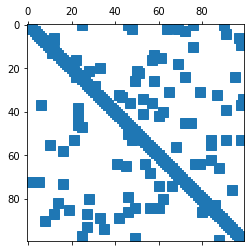

In [2]:
n = 100
A = sparse.random(n, n, 0.01) + sparse.eye(n)
plt.spy(A)
plt.show()

In [3]:
A = A.tocsc() # need to convert to CSC form first
LU = sla.splu(A)
LU

The resulting object stores the factors necessary to compute `A = PLUQ` (`P` permutes rows, and `Q` permutes columns).  It is computed using the [SuperLU library](https://portal.nersc.gov/project/sparse/superlu/).  Typically, you will just use the `solve` method on this object.

In [4]:
x = np.random.randn(n)
b = A @ x

x2 = LU.solve(b)
print(np.linalg.norm(x2 - x))

6.255500407745403e-16


you can also use the `sla.spsolve` function, which wraps this factorization.

In [5]:
x2 = sla.spsolve(A, b)
print(np.linalg.norm(x2 - x))

6.255500407745403e-16


## Sparse Iterative Methods

Sparse iterative methods are another class of methods you can use for solving linear systems built on [Krylov subspaces](https://en.wikipedia.org/wiki/Krylov_subspace).  They only require matrix-vector products, and are ideally used with sparse matrices and fast linear operators.  You can typically learn the theory behind these methods in a numerical linear algebra course - we'll just talk about how to use them. 

All these methods are meant to solve linear systems: find `x` so that `A @ x = b`, or least squares problems minimizing `norm(A @ x - b)`

You can find a list of options in the [documentation for `scipy.sparse.linalg`](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html#solving-linear-problems).  Here are some common options:

* Conjugate Gradient: `sla.cg` for `A` SPD
* MINRES: `sla.minres` for `A` symmetric
* GMRES: `sla.gmres` for general square `A`
* LSQR: `sla.lsqr` for solving least squares problems

For example, we can use `gmres` with the same matrix we used for `splu`:

In [6]:
x2, exit = sla.gmres(A, b, tol=1e-8) # exit code: 0 if successful
print(np.linalg.norm(x2 - x))

1.2520036319259435e-08


In [7]:
import time
x2 = np.empty_like(x)

t0 = time.time()
x2, exit = sla.gmres(A, b)
t1 = time.time()
print("GMRES in {} sec.".format(t1 - t0))

t0 = time.time()
x2 = sla.spsolve(A, b)
t1 = time.time()
print("spsolve in {} sec.".format(t1 - t0))

GMRES in 0.003651142120361328 sec.
spsolve in 0.0023009777069091797 sec.


### Sparse Direct vs. Iterative Methods

There are a couple of trade offs to consider when deciding whether to use sparse direct or iterative algorithms.

1.  Are you going to be solving many linear systems with the same matrix `A`?  If so, you can produce a single factorization object using `splu`, and use it to solve many right-hand sides.  Sparse direct probably makes more sense.
2. Are you solving a single linear system?  If so, then a single call to an iterative method probably makes mores sense.
3. Are you using a fast linear operator that could be expressed as a dense matrix (e.g. sparse plus low-rank)?  Alternatively, would the sparse LU decomposition turn dense because of fill-in?  If so, then iterative methods probably make more sense.
4. Do you have a really good preconditioner (see below)?  Then iterative methods probably make more sense.

### Preconditioning

The speed/effectiveness of iterative methods is often dependent on the existence of a good preconditioner. A preconditioner `M` for a matrix `A` is an "approximate inverse" i.e. `M @ A` is close to the identity.  Note if we had an exact inverse, we've solved our problem already.  What we want is to have a matrix `M` which is fast to apply (i.e. also sparse like `A`), which generally isn't possible with an exact inverse.

Finding a good preconditioner is a huge field of research, and can be very domain-dependent.  A general-purpose method to obtain a preconditioner is to use an Incomplete LU decomposition (this is an LU factorization that stops when the fill-in gets too large). You can obtain one using `sla.spilu`.

In [8]:
ILUfact = sla.spilu(A)

You can construct a preconditioner using a `LinearOperator` around the ILU object's solve method

In [9]:
M = sla.LinearOperator(
    shape = A.shape,
    matvec = lambda b: ILUfact.solve(b)
)

In [10]:
x2, exit = sla.gmres(A, b, M=M) # exit code: 0 if successful
print(np.linalg.norm(x2 - x))

2.049900792337724e-15


In [12]:
t0 = time.time()
x2, exit = sla.gmres(A, b)
t1 = time.time()
print("GMRES in {:.3e} sec.".format(t1 - t0))
print(np.linalg.norm(x2 - x))

t0 = time.time()
x2, exit = sla.gmres(A, b, M=M)
t1 = time.time()
print("preconditioned GMRES in {:.3e} sec.".format(t1 - t0))
print(np.linalg.norm(x2 - x))

GMRES in 3.592e-03 sec.
9.782526966241209e-05
preconditioned GMRES in 2.817e-03 sec.
2.049900792337724e-15


We get a higher-precision answer in about the same amount of time.

## Eigenvalues and Eigenvectors

Computing a full eigenvalue decomposition of a sparse matrix or fast linear operator doesn't typically make sense (see the the discussion for sparse direct methods).  However, there are a lot of situations in which we want to compute the eigenvalue-eigenvector pairs for a handful of the largest (or smallest) eigenvalues.  

`scipy.sparse.linalg` wraps [ARPACK (ARnoldi PACKage)](https://www.caam.rice.edu/software/ARPACK/), which uses Krylov subspace techniques (like the iterative methods) to compute eigenvalues/eigenvectors using matrix-vector multiplications.  The relevant methods are `sla.eigs` (for general square matrices) and `sla.eigsh` (for symmetric/Hermitian matrices).  There is also a `sla.svds` function for the SVD.

Let's look at an example for a linear operator which acts as the matrix of all ones.

In [13]:
# works on square matrices
Afun = lambda X : np.sum(X, axis=0).reshape(1,-1).repeat(X.shape[0], axis=0)

m = 10 # linear operator of size 10

A = sla.LinearOperator(
    shape   = (m,m),
    matvec  = Afun,
    rmatvec = Afun,
    matmat  = Afun,
    rmatmat = Afun,
    dtype=np.float   
)

This operator is Hermitian, so we'll use `eigsh`.  By default, `eigsh` will compute the largest magnitude eigenvalues.  You can change which eigenvalues you're looking for using the `which` keyword argument, and the number of eigenvalues using the `k` argument.  See [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html#scipy.sparse.linalg.eigsh) for details.

In [14]:
Lam, V = sla.eigsh(A)

In [15]:
Lam

array([-5.86174617e-18, -3.50871500e-32,  2.38837756e-32,  2.87286167e-32,
        1.78221859e-15,  1.00000000e+01])

we see there is one eigenvalue with a numerically non-zero value (10).  Let's take a look at the eigenvector

In [16]:
V[:,-1]

array([-0.31622777, -0.31622777, -0.31622777, -0.31622777, -0.31622777,
       -0.31622777, -0.31622777, -0.31622777, -0.31622777, -0.31622777])

this is the vector with constant entries.  This agrees with our understanding of the operator `A`, which can be expressed as the symmetric rank-1 outer product of the vector with 1s in every entry.

## Randomized Linear Algebra

In the past decade or two, randomized linear algebra has matured as a topic with lots of practical applications.  To read about the theory, see the 2009 paper by Halko, Martinsson, and Tropp: [Link](http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf).

SciPy does not (currently) have built-in functions for randomized linear algebra functionality (some languages like Julia do).  Fortunately, these algorithms are very easy to implement without worrying too much about the theory.

For simplicity, we'll assume that `A` is symmetric with distinct eigenvectors, so we can limit the discussion to eigenvectors.  A rank-`k` approximation of `A` is an approximation by a rank-`k` outer product.  We can analyitically obtain the optimal rank-`k` approximation by computing a full eigenvalue decomposition of `A` and set all the eigenvalues outside the largest `k` (in magnitude) to 0.  Again, we don't want to actually compute the full eigenvalue decomposition, so we want an algorithm that does this in some provable way.

The basic idea is to get an approximation of the range of an operator `A` by applying it to a bunch of random vectors. That is, we compute `A @ X`, where `X` is a matrix with random entries (we think of every column as a random vector). One way to think about the action of `A` is that it "rotates" these random vectors preferentially in the direction of the top eigenvectors, so if we look at the most important subspace of the span of the image  `A @ X` (as measured by the svd), we get a good approximation of the most important eigenspace.

Randomized algorithms have probabilistic gurarantees.  The statement is roughly that if entries of `X` are iid sub-Gaussian random variables (you can replace "sub-Gaussian" with Gaussian), and if we use `k+p` random vectors (`p` is a small constant), we can get close to the top-`k` dimensional eigenspace *with high probability*.  In this case, *close* depends on something called the spectral gap, and *with high probability* means that in order to **not** be close to the desired subspace you would likely need to keep running computations with different random numbers for millions or billions of years before you would observe the algorithm fail.

Let's see how this works in practice:

In [44]:
import scipy.linalg as la

def random_span_k_svd(A, k, p=10, power=0):
    """
    Compute subspace whose span is close to contaning the top-k eigenspace of A
    
    p = number of dimensions to pad
    power : number of times to run a power iteration on the subspace
    """
    m, n = A.shape
        
    X = np.random.randn(n, k+p)
    Y = A @ X
    
    U, s, Vt = la.svd(Y, full_matrices=False)
    
    for i in range(power):
        Y = A @ U
        U, s, Vt = la.svd(Y, full_matrices=False)
    
    
    return U

Here's a version that uses `orgqr` from LAPACK

In [45]:
from scipy.linalg import lapack

def random_span_k(A, k, p=10, power=0):
    """
    Compute subspace whose span is close to contaning the top-k eigenspace of A
    
    p = number of dimensions to pad
    power : number of times to run a power iteration on the subspace
    """
    m, n = A.shape
        
    X = np.random.randn(n, k+p)
    Y = A @ X
    
    m, n = Y.shape
    lwork = max(3*n, 1)
    qr, tau, work, info = lapack.dgeqrf(Y, lwork, 1) # overwrite A = True
    Y, work, info = lapack.dorgqr(qr, tau, lwork, 1) # overwrite qr = True
    
    for i in range(power):
        Y = A @ Y
        qr, tau, work, info = lapack.dgeqrf(Y, lwork, 1) # overwrite A = True
        Y, work, info = lapack.dorgqr(qr, tau, lwork, 1) # overwrite qr = True
    
    
    return Y

Let's test this on a diagonal matrix with entries 0 to `n-1` along the main diagonal.  In this case, the eigenvalues are integers, and the eigenvectors are the standard basis vectors.

In [28]:
n = 100
D = sparse.dia_matrix((np.arange(n), [0]), shape=(n,n))
D

<100x100 sparse matrix of type '<class 'numpy.int64'>'
	with 100 stored elements (1 diagonals) in DIAgonal format>

Let's compare the two versions

In [1]:
k = 5

In [57]:
%timeit U = random_span_k_svd(D, k)

457 µs ± 8.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [58]:
%timeit U = random_span_k(D, k)

324 µs ± 8.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [59]:
k = 5
U = random_span_k(D, k)

In [60]:
lam, V = la.eigh(D.todense())
V_true = V[:,-k:]
V_true[-k:,:] # should see identity

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

Let's take a look at how well `U` captures each eigenvector.  The distance from this subspace from the `i`th eigenvector is `norm(V[:,i].T*U)`.  Because the eigenvectors are canonical basis vectors, this is just the norm of the `i`th row of `U`

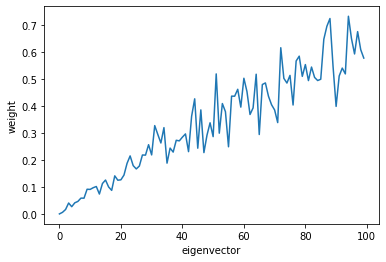

In [61]:
Ui_norms = []
for i in range(n):
    Ui_norms.append(np.linalg.norm(U[i]))
#     print("{:02d} : {}".format(i, np.linalg.norm(U[i])))

plt.plot(Ui_norms)
plt.xlabel('eigenvector')
plt.ylabel('weight')
plt.show()

As we see, `U` is closer to the larger eigenvectors, rather than the smaller eigenvectors.

We can improve this estimate by running a couple of power iterations on the subspace (the `power` keyword defined above):

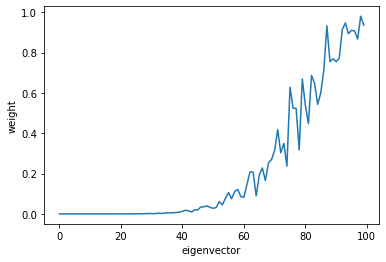

In [62]:
U = random_span_k(D, k, power=5)
Ui_norms = []
for i in range(n):
    Ui_norms.append(np.linalg.norm(U[i]))
    
#     print("{:02d} : {}".format(i, np.linalg.norm(U[i])))

plt.plot(Ui_norms)
plt.xlabel('eigenvector')
plt.ylabel('weight')
plt.show()

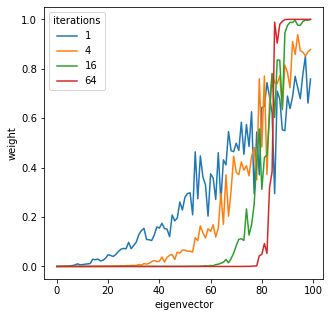

In [63]:
powers = [1, 4, 16, 64]

fig, ax = plt.subplots(figsize=(5,5))

for pi, power in enumerate(powers):
    U = random_span_k(D, k, power=power)
    Ui_norms = []
    for i in range(n):
        Ui_norms.append(np.linalg.norm(U[i]))

    #     print("{:02d} : {}".format(i, np.linalg.norm(U[i])))

    ax.plot(Ui_norms, label="{}".format(power))
    
ax.set_xlabel('eigenvector')
ax.set_ylabel('weight')

plt.legend(title='iterations')
plt.show()


## Exercises

Download a couple of test matrices from the UFlorida Sparse Matrix collection [Link](https://sparse.tamu.edu/)
For, example, use `mnist_test_norm_10NN` [Link](https://sparse.tamu.edu/ML_Graph/mnist_test_norm_10NN) which would probably be too large to store on your computer as a dense matrix.

For each square matrix:
1. Solve a random linear system using `splu`
2. Solve a random linear system using either `minres` or `gmres` (which one should you use?)
3. Compute the largest magnitude eigenvector using `eigs` or `eigsh` (which one should you use?)

Find a non-square matrix and
1. Solve a random least squares problem using `lsqr`
2. Compute the largest singular vectors using `svds`

In [ ]:
## Your code here
